In [1]:
import numpy as np
import pandas as pd 
import os

#读取csv文件时调整路径

In [5]:
#导入相关包
import matplotlib.pyplot as plt 
import seaborn as sns
from  pylab import rcParams
import matplotlib.cm as cm

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder               # 编码转换
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier          # 随机森林
from sklearn.svm import SVC, LinearSVC                       # 支持向量机
from sklearn.linear_model import LogisticRegression          # 逻辑回归
from sklearn.neighbors import KNeighborsClassifier           # KNN算法
from sklearn.naive_bayes import GaussianNB                   # 朴素贝叶斯
from sklearn.tree import DecisionTreeClassifier              # 决策树分类器
#from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import GradientBoostingClassifier     

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

get_ipython().magic('matplotlib inline')

# 1.导入数据

In [83]:
os.getcwd()
#俺来瞅瞅工作路径
data=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 2.查看数据集信息

In [84]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [85]:
data.shape

(7043, 21)

In [86]:
# 获取数据类型列的描述统计信息
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# 3.数据清洗

In [49]:
# 查找缺失值
np.all(pd.notnull(data))

True

In [50]:
data["Churn"].value_counts()

# 数据集中有5174名用户没流失，有1869名客户流失，数据集不均衡。

No     5174
Yes    1869
Name: Churn, dtype: int64

In [51]:
data.info()
# TotalCharges表示总费用，这里为对象类型，需要转换为float类型  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [52]:
data['TotalCharges']=data['TotalCharges'].apply(pd.to_numeric, errors='coerce')
# convert_numeric已经不能用啦!时代变啦大人！
data["TotalCharges"].dtypes

dtype('float64')

In [53]:
#再一次查缺时发现有问题！
np.all(pd.notnull(data))

False

In [54]:
#删除缺失值所在的行
data.dropna(inplace=True)
data.shape

(7032, 21)

# 4.数据归一化处理

In [55]:

# 对Churn 列中的值 Yes和 No分别用 1和 0替换，方便后续处理
data['Churn'].replace(to_replace = 'Yes', value = 1,inplace = True)
data['Churn'].replace(to_replace = 'No', value = 0,inplace = True)
data['Churn'].head(10)

0    0
1    0
2    1
3    0
4    1
5    1
6    0
7    0
8    1
9    0
Name: Churn, dtype: int64

#  4.数据可视化呈现

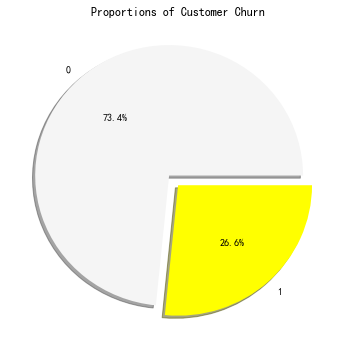

In [56]:

# 查看流失客户占比，画个饼图给俺瞅瞅
"""
画饼图参数：
labels  (每一块)饼图外侧显示的说明文字
explode  (每一块)离开中心距离
startangle  起始绘制角度,默认图是从x轴正方向逆时针画起,如设定=90则从y轴正方向画起
shadow   是否阴影
labeldistance label  绘制位置,相对于半径的比例, 如<1则绘制在饼图内侧
autopct   控制饼图内百分比设置,可以使用format字符串或者format function
     '%1.1f'指小数点前后位数(没有用空格补齐)
pctdistance 类似于labeldistance,指定autopct的位置刻度
radius   控制饼图半径
"""
churnvalue=data["Churn"].value_counts()
labels=data["Churn"].value_counts().index

rcParams["figure.figsize"]=6,6
plt.pie(churnvalue,labels=labels,colors=["whitesmoke","yellow"], explode=(0.1,0),autopct='%1.1f%%', shadow=True)
plt.title("Proportions of Customer Churn")
plt.show()

In [57]:
%matplotlib inline 
#懒地写show（）了

Text(0.5,1,'Churn by Dependents')

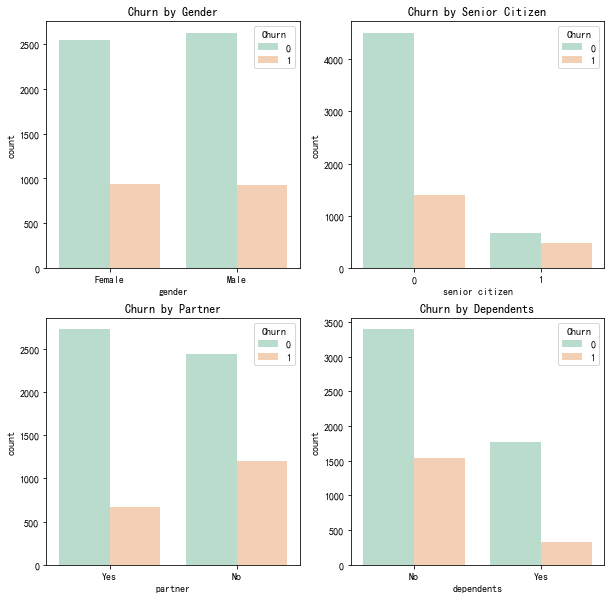

In [58]:
# 性别、老年人、配偶、亲属对流客户流失率的影响
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

plt.subplot(2,2,1)
gender=sns.countplot(x="gender",hue="Churn",data=data,palette="Pastel2") # palette参数表示设置颜色，这里设置为主题色Pastel2
plt.xlabel("gender")
plt.title("Churn by Gender")

plt.subplot(2,2,2)
seniorcitizen=sns.countplot(x="SeniorCitizen",hue="Churn",data=data,palette="Pastel2")
plt.xlabel("senior citizen")
plt.title("Churn by Senior Citizen")

plt.subplot(2,2,3)
partner=sns.countplot(x="Partner",hue="Churn",data=data,palette="Pastel2")
plt.xlabel("partner")
plt.title("Churn by Partner")

plt.subplot(2,2,4)
dependents=sns.countplot(x="Dependents",hue="Churn",data=data,palette="Pastel2")
plt.xlabel("dependents")
plt.title("Churn by Dependents")


In [59]:
# 提取特征
charges=data.iloc[:,1:20]
# 对特征进行编码
"""
离散特征的编码分为两种情况：
1、离散特征的取值之间没有大小的意义，比如color：[red,blue],那么就使用one-hot编码
2、离散特征的取值有大小的意义，比如size:[X,XL,XXL],那么就使用数值的映射{X:1,XL:2,XXL:3}
"""
corrDf = charges.apply(lambda x: pd.factorize(x)[0])
corrDf .head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,1,1
2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,2,2
3,1,0,1,0,3,0,0,0,1,1,1,1,0,0,1,1,2,3,3
4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,4,4


In [60]:
# 构造相关性矩阵
corr = corrDf.corr()
corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
gender,1.000000,-0.001819,0.001379,0.010349,-0.000265,-0.007515,-0.010284,-0.002236,-0.004365,0.011081,0.004526,0.000057,0.000578,-0.001339,0.000095,0.011902,-0.004928,-0.008017,-0.012153
SeniorCitizen,-0.001819,1.000000,-0.016957,-0.210550,0.012240,0.008392,0.113769,-0.032160,-0.210546,-0.144762,-0.156700,-0.223438,-0.129721,-0.120658,-0.141820,-0.156258,-0.093712,0.049154,0.022949
Partner,0.001379,-0.016957,1.000000,-0.452269,-0.100513,-0.018397,-0.118037,-0.000513,-0.081078,0.091536,-0.093391,-0.068277,-0.079066,-0.075310,-0.294094,-0.013957,-0.133280,-0.036518,-0.044214
Dependents,0.010349,-0.210550,-0.452269,1.000000,0.044138,-0.001078,-0.019178,0.044030,0.188889,0.061970,0.154819,0.179176,0.138809,0.125086,0.240556,0.110131,0.124002,-0.028706,0.009710
tenure,-0.000265,0.012240,-0.100513,0.044138,1.000000,-0.017864,0.064580,-0.012924,0.014436,-0.066232,0.034744,0.030489,0.024719,0.030252,0.118664,-0.013160,0.075533,0.042605,0.112813
PhoneService,-0.007515,0.008392,-0.018397,-0.001078,-0.017864,1.000000,0.674824,0.387266,0.125544,0.129432,0.138938,0.123533,0.171773,0.164379,0.003019,-0.016696,-0.003106,-0.141696,-0.030534
MultipleLines,-0.010284,0.113769,-0.118037,-0.019178,0.064580,0.674824,1.000000,0.186852,-0.066695,-0.130978,-0.012819,-0.066814,0.030524,0.027944,0.084037,-0.133538,0.026248,0.024221,0.014915
InternetService,-0.002236,-0.032160,-0.000513,0.044030,-0.012924,0.387266,0.186852,1.000000,0.607412,0.650084,0.662685,0.609422,0.712715,0.708336,0.099579,0.138166,0.008851,-0.288948,-0.037709
OnlineSecurity,-0.004365,-0.210546,-0.081078,0.188889,0.014436,0.125544,-0.066695,0.607412,1.000000,0.621270,0.748684,0.790951,0.701526,0.704672,0.389138,0.333656,0.214330,-0.219289,-0.024821
OnlineBackup,0.011081,-0.144762,0.091536,0.061970,-0.066232,0.129432,-0.130978,0.650084,0.621270,1.000000,0.600952,0.616520,0.603551,0.606037,0.034745,0.260691,0.003786,-0.283212,-0.053770


Text(0.5,1,'Correlation between variables')

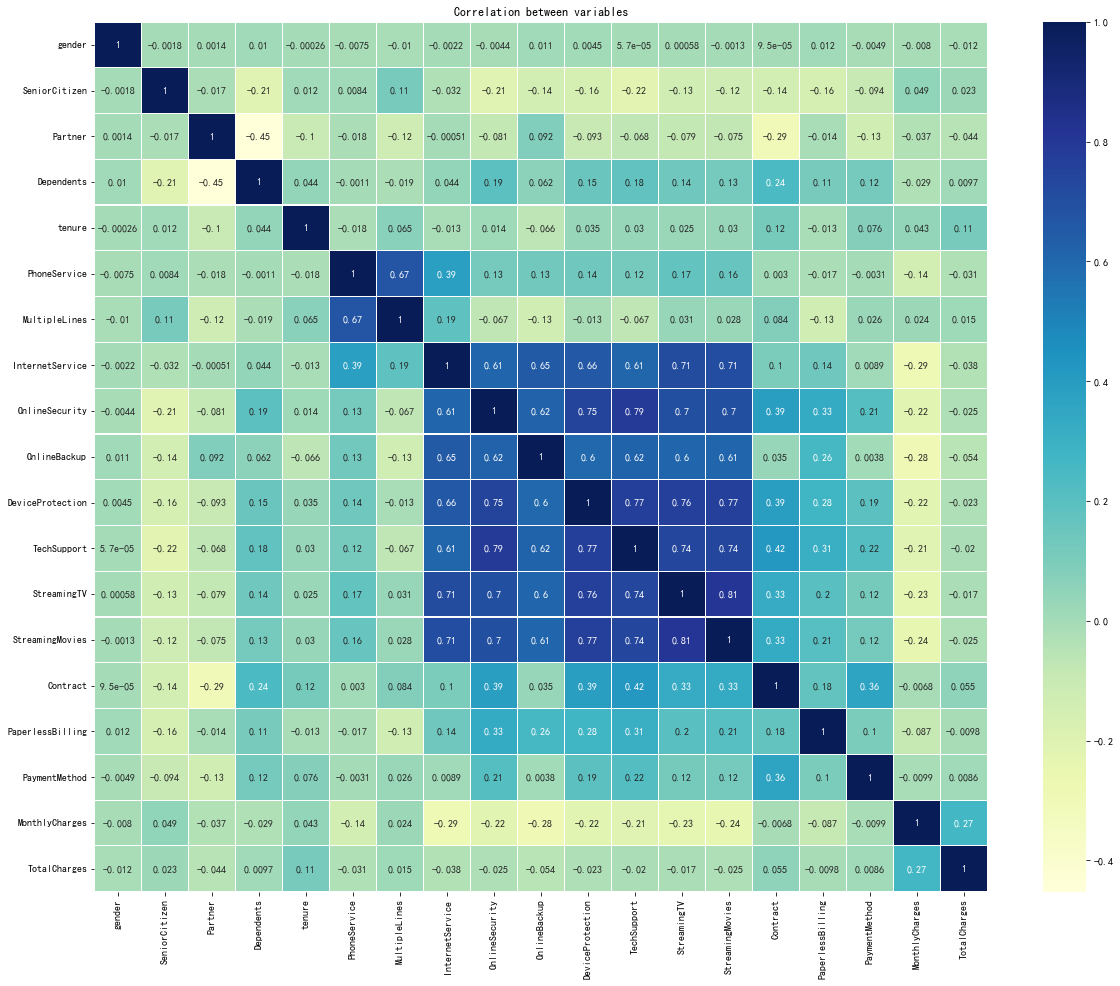

In [61]:
# 使用热地图显示相关系数
'''
heatmap    使用热地图展示系数矩阵情况
linewidths 热力图矩阵之间的间隔大小
annot      设定是否显示每个色块的系数值
'''
plt.figure(figsize=(20,16))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=0.2, cmap="YlGnBu",annot=True)
plt.title("Correlation between variables")
# 结论：从上图可以看出，互联网服务、网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视和网络电影之间存在较强的相关性，多线业务和电话服务之间也有很强的相关性，并且都呈强正相关关系。


In [62]:
# 使用one-hot编码
tel_dummies = pd.get_dummies(data.iloc[:,1:21])
tel_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


Text(0.5,1,'Correlations between Churn and variables')

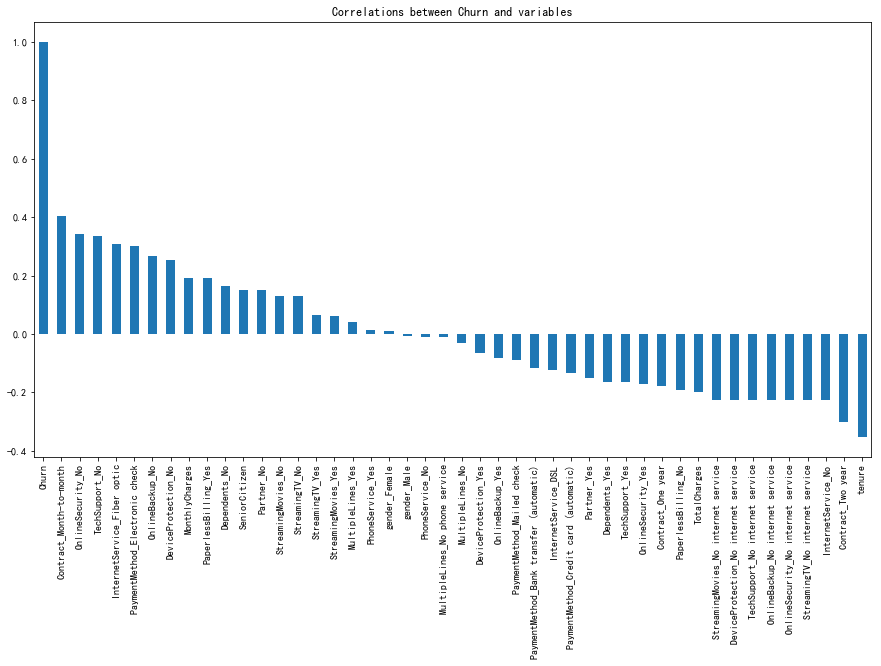

In [63]:

# 电信用户是否流失与各变量之间的相关性
plt.figure(figsize=(15,8))
tel_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')
plt.title("Correlations between Churn and variables")
# 由图上可以看出，变量gender 和 PhoneService 处于图形中间，其值接近于 0 ，这两个变量对电信客户流失预测影响非常小，可以直接舍弃。

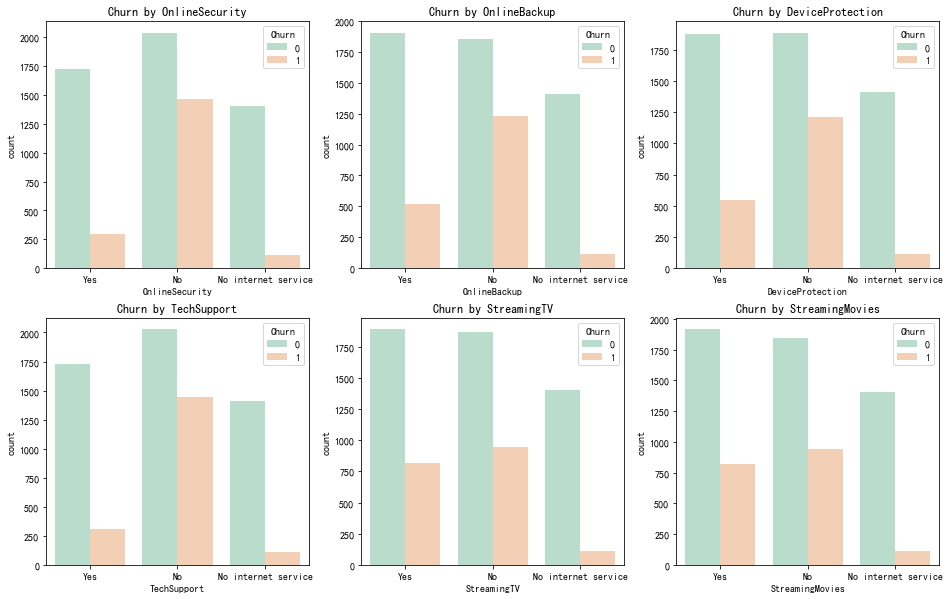

In [64]:
# 网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视、网络电影和无互联网服务对客户流失率的影响
covariables=["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(16,10))
for i, item in enumerate(covariables):
    plt.subplot(2,3,(i+1))
    ax=sns.countplot(x=item,hue="Churn",data=data,palette="Pastel2",order=["Yes","No","No internet service"])
    plt.xlabel(str(item))
    plt.title("Churn by "+ str(item))
    i=i+1
     
#由上图可以看出，在网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视和网络电影六个变量中，没有互联网服务的客户流失率值是相同的，都是相对较低。

    # 这可能是因为以上六个因素只有在客户使用互联网服务时才会影响客户的决策，这六个因素不会对不使用互联网服务的客户决定是否流失产生推论效应。


Text(0.5,1,'Churn by Contract type')

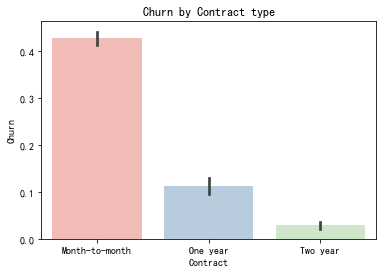

In [65]:
# 签订合同方式对客户流失率的影响
sns.barplot(x="Contract",y="Churn", data=data, palette="Pastel1", order= ['Month-to-month', 'One year', 'Two year'])
plt.title("Churn by Contract type")
# 由图上可以看出，签订合同方式对客户流失率影响为：按月签订 > 按一年签订 > 按两年签订，这可能表明，设定长期合同对留住现有客户更有效。


Text(0.5,1,'Churn by PaymentMethod type')

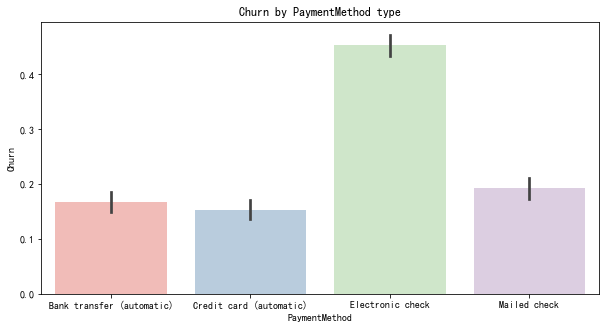

In [66]:
# 付款方式对客户流失率的影响
plt.figure(figsize=(10,5))
sns.barplot(x="PaymentMethod",y="Churn", data=data, palette="Pastel1", order= ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check','Mailed check'])
plt.title("Churn by PaymentMethod type")


# 由图上可以看出，在四种支付方式中，使用Electronic check的用户流流失率最高，其他三种支付方式基本持平，因此可以推断电子账单在设计上影响用户体验。


 # 5.数据预处理

In [67]:
# 由前面结果可知，CustomerID表示每个客户的随机字符，对后续建模不影响，我这里选择删除CustomerID列；gender 和 PhoneService 与流失率的相关性低，可直接忽略。
telcomvar=data.iloc[:,2:20]
telcomvar.drop("PhoneService",axis=1, inplace=True)

In [68]:
# 提取ID
telcom_id = data['customerID']
telcomvar.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [69]:
# 对客户的职位、月费用和总费用进行去均值和方差缩放，对数据进行标准化
"""
标准化数据，保证每个维度的特征数据方差为1，均值为0，使得预测结果不会被某些维度过大的特征值而主导。
"""
scaler = StandardScaler(copy=False)
# fit_transform()的作用就是先拟合数据，然后转化它将其转化为标准形式
scaler.fit_transform(telcomvar[['tenure','MonthlyCharges','TotalCharges']])


array([[-1.28024804, -1.16169394, -0.99419409],
       [ 0.06430269, -0.26087792, -0.17373982],
       [-1.23950408, -0.36392329, -0.95964911],
       ...,
       [-0.87280842, -1.17000405, -0.85451414],
       [-1.15801615,  0.31916782, -0.87209546],
       [ 1.36810945,  1.35793167,  2.01234407]])

In [70]:
# tranform()的作用是通过找中心和缩放等实现标准化
telcomvar[['tenure','MonthlyCharges','TotalCharges']]=scaler.transform(telcomvar[['tenure','MonthlyCharges','TotalCharges']])


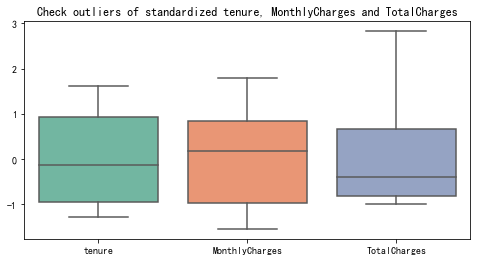

In [71]:
plt.figure(figsize = (8,4))
numbox = sns.boxplot(data=telcomvar[['tenure','MonthlyCharges','TotalCharges']], palette="Set2")
plt.title("Check outliers of standardized tenure, MonthlyCharges and TotalCharges")
plt.rcParams['axes.unicode_minus']=False 
#负号显示问题
# 由以上结果可以看出，在三个变量中不存在明显的异常值


In [72]:
# 查看对象类型字段中存在的值
def uni(columnlabel):
    print(columnlabel,"--" ,telcomvar[columnlabel].unique())  # unique函数去除其中重复的元素，返回唯一值
    
telcomobject=telcomvar.select_dtypes(['object'])
for i in range(0,len(telcomobject.columns)):
    uni(telcomobject.columns[i])


# 综合之前的结果来看，在六个变量中存在No internet service，即无互联网服务对客户流失率影响很小，这些客户不使用任何互联网产品，因此可以将No internet service 和 No 是一样的效果，可以使用 No 替代 No internet service


Partner -- ['Yes' 'No']
Dependents -- ['No' 'Yes']
MultipleLines -- ['No phone service' 'No' 'Yes']
InternetService -- ['DSL' 'Fiber optic' 'No']
OnlineSecurity -- ['No' 'Yes' 'No internet service']
OnlineBackup -- ['Yes' 'No' 'No internet service']
DeviceProtection -- ['No' 'Yes' 'No internet service']
TechSupport -- ['No' 'Yes' 'No internet service']
StreamingTV -- ['No' 'Yes' 'No internet service']
StreamingMovies -- ['No' 'Yes' 'No internet service']
Contract -- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -- ['Yes' 'No']
PaymentMethod -- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [73]:
telcomvar.replace(to_replace='No internet service', value='No', inplace=True)
telcomvar.replace(to_replace='No phone service', value='No', inplace=True)
for i in range(0,len(telcomobject.columns)):
    uni(telcomobject.columns[i])

Partner -- ['Yes' 'No']
Dependents -- ['No' 'Yes']
MultipleLines -- ['No' 'Yes']
InternetService -- ['DSL' 'Fiber optic' 'No']
OnlineSecurity -- ['No' 'Yes']
OnlineBackup -- ['Yes' 'No']
DeviceProtection -- ['No' 'Yes']
TechSupport -- ['No' 'Yes']
StreamingTV -- ['No' 'Yes']
StreamingMovies -- ['No' 'Yes']
Contract -- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -- ['Yes' 'No']
PaymentMethod -- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [74]:
# 使用Scikit-learn标签编码,将分类数据转换为整数编码
def labelencode(columnlabel):
    telcomvar[columnlabel] = LabelEncoder().fit_transform(telcomvar[columnlabel])
    
for i in range(0,len(telcomobject.columns)):
    labelencode(telcomobject.columns[i])
    
for i in range(0,len(telcomobject.columns)):
    uni(telcomobject.columns[i])

Partner -- [1 0]
Dependents -- [0 1]
MultipleLines -- [0 1]
InternetService -- [0 1 2]
OnlineSecurity -- [0 1]
OnlineBackup -- [1 0]
DeviceProtection -- [0 1]
TechSupport -- [0 1]
StreamingTV -- [0 1]
StreamingMovies -- [0 1]
Contract -- [0 1 2]
PaperlessBilling -- [1 0]
PaymentMethod -- [2 3 0 1]


# 6.构建模型

## （1）建立训练数据集和测试数据集

In [75]:
"""
我们需要将数据集拆分为训练集和测试集以进行验证。
由于我们所拥有的数据集是不平衡的，所以最好使用分层交叉验证来确保训练集和测试集都包含每个类样本的保留人数。
交叉验证函数StratifiedShuffleSplit，功能是从样本数据中随机按比例选取训练数据（train）和测试数据（test）
参数 n_splits是将训练数据分成train/test对的组数，可根据需要进行设置，默认为10
参数test_size和train_size是用来设置train/test对中train和test所占的比例
参数 random_state控制是将样本随机打乱
"""
X=telcomvar
y=data["Churn"].values

sss=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print(sss)
print("训练数据和测试数据被分成的组数：",sss.get_n_splits(X,y))

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)
训练数据和测试数据被分成的组数： 5


In [76]:
# 建立训练数据和测试数据
for train_index, test_index in sss.split(X, y):
    print("train:", train_index, "test:", test_index)
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y[train_index], y[test_index]

train: [3780 1588 2927 ... 3956 6130 6814] test: [5126 2423 2498 ... 6703 6618 6010]
train: [6916 6953 5388 ... 6156 3262 3471] test: [4097 4734 2309 ... 1278 1724 5508]
train: [1218 2877 3756 ...  848 4568 6967] test: [ 133 1822 5303 ... 3150 5611 4569]
train: [2552 4723 2055 ... 4030 2165 1994] test: [ 233  438 4434 ... 4625 1121 3422]
train: [4040 1561 6463 ... 2550 6727 4009] test: [4581 3898 3153 ... 2095 1765 2249]


In [77]:
# 输出数据集大小
print('原始数据特征：', X.shape,
      '训练数据特征：',X_train.shape,
      '测试数据特征：',X_test.shape)

print('原始数据标签：', y.shape,
      '   训练数据标签：',y_train.shape,
      '   测试数据标签：',y_test.shape)


原始数据特征： (7032, 17) 训练数据特征： (5625, 17) 测试数据特征： (1407, 17)
原始数据标签： (7032,)    训练数据标签： (5625,)    测试数据标签： (1407,)


## （2）选择机器学习算法

In [87]:
# 使用分类算法，这里选用几种分类算法
Classifiers=[["Random Forest",RandomForestClassifier()],
             ["Support Vector Machine",SVC()],
             ["LogisticRegression",LogisticRegression()],
             ["KNN",KNeighborsClassifier(n_neighbors=5)],
             ["Naive Bayes",GaussianNB()],
             ["Decision Tree",DecisionTreeClassifier()],
]


## （3）训练模型

In [89]:
Classify_result=[]
names=[]
prediction=[]
for name,classifier in Classifiers:
    classifier=classifier
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    
    recall=recall_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    f1score=f1_score(y_test,y_pred)
    class_eva=pd.DataFrame([recall,precision,f1score])
    Classify_result.append(class_eva)
    
    name=pd.Series(name)
    names.append(name)
    y_pred=pd.Series(y_pred)
    prediction.append(y_pred)



##  (4）评估模型

In [90]:
# 评估模型
"""
召回率（recall）的含义是：原本为对的当中，预测为对的比例（值越大越好，1为理想状态）
精确率、精度（precision）的含义是：预测为对的当中，原本为对的比例（值越大越好，1为理想状态）
F1分数（F1-Score）指标综合了Precision与Recall的产出的结果
F1-Score的取值范围从0到1的，1代表模型的输出最好，0代表模型的输出结果最差。
"""

names=pd.DataFrame(names)
names=names[0].tolist()
result=pd.concat(Classify_result,axis=1)
result.columns=names
result.index=["recall","precision","f1score"]
result

# 综上所述，在几种分类算法中使用朴素贝叶斯（Naive Bayes）模型效果最好。

,Random Forest,Support Vector Machine,LogisticRegression,KNN,Naive Bayes,Decision Tree
recall,0.451872,0.459893,0.548128,0.478610,0.740642,0.532086
precision,0.605735,0.696356,0.652866,0.561129,0.552894,0.508951
f1score,0.517611,0.553945,0.595930,0.516595,0.633143,0.520261


#  7.实施方案

In [81]:
# 7、实施方案

# 预测数据集特征（由于没有提供预测数据集，这里选取后10行作为需要预测的数据集）
pred_X = telcomvar.tail(10)

# 提取customerID
pre_id = telcom_id.tail(10)

# 使用朴素贝叶斯方法，对预测数据集中的生存情况进行预测
model = GaussianNB()
model.fit(X_train,y_train)
pred_y = model.predict(pred_X)

# 预测结果
predDf = pd.DataFrame({'customerID':pre_id, 'Churn':pred_y})
predDf

,customerID,Churn
7033,9767-FFLEM,1
7034,0639-TSIQW,0
7035,8456-QDAVC,1
7036,7750-EYXWZ,0
7037,2569-WGERO,0
7038,6840-RESVB,0
7039,2234-XADUH,0
7040,4801-JZAZL,0
7041,8361-LTMKD,1
7042,3186-AJIEK,0
